## Read in the data and take care of it

In [23]:
import json

DATAPATH = "data/articles.json"

with open(DATAPATH, "r", encoding="utf-8") as f:
    articles = json.load(f)
    
all_categories = []
articles_dict = dict()
for article in articles:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
n_categories = len(articles_dict.keys())
n_letters = 257 # the first 256 ASCII characters + a "bin" for weird characters

## Turning abstracts into pytorch tensors

In [18]:
import torch

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for idx, char in enumerate(line):
        encoding = ord(char)
        if encoding > 256:
            encoding = 256
        tensor[idx, 0, encoding] = 1
    return tensor

#print(lineToTensor("abc"))

## Creating the RNN architecture

In [20]:
import torch.nn as nn

n_hidden = 128

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.LSTM(input_size, hidden_size, 1)
        
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        hidden , (h_t, c_t) = self.i2h(input)
        output = self.h2o(hidden[-1])
        output = self.softmax(output)
        return output
    
rnn=LSTM(n_letters, n_hidden, n_categories)

In [22]:
inp = lineToTensor("Rodrigo is my name")
output = rnn(inp)
print(output)

tensor([[-2.1208, -2.1379, -1.9981, -2.1328, -2.1102, -1.9986, -1.9966, -2.1581]],
       grad_fn=<LogSoftmaxBackward>)


## Preparing for training

In [36]:
def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(rnn(lineToTensor("some random line here"))))

('Quantitative Finance', 6)


In [33]:
from random import choice

def randomTrainingExample():
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor, abstract_tensor

randomTrainingExample()

('Quantitative Biology',
 'By starting from the four DNA bases order in the Boolean lattice, a novel Lie\nAlgebra of the genetic code is proposed. Here, the principal partitions of the\ngenetic code table were obtained as equivalent classes of quotient subspaces of\nthe genetic code vector space over the Galois field of the four DNA bases. The\nnew algebraic structure shows strong connections among algebraic relationships,\ncodon assignment and physicochemical properties of amino acids. Moreover, a\ndistance function defined between codons in the Lie algebra was demonstrated to\nhave a linear behavior respect to physical variables such as the mean of amino\nacids energy in proteins. It was also noticed that the distance between wild\ntype and mutant codons approach smaller values in mutational variants of four\ngenes, i.e, human phenylalanine hydroxylase, human beta-globin, HIV-1 protease\nand HIV-1 reverse transcriptase. These results strongly suggest that\ndeterministic rules in gene

## Training the network

In [34]:
criterion = nn.NLLLoss()

learning_rate = 0.005

def train(category_tensor, abstract_tensor):
    rnn.zero_grad()
    
    output = rnn(abstract_tensor)
            
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # manually perform the optimizer step
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

In [37]:
import time

n_iters = 100
print_every = 5
plot_every = 1

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

start = time.time()

for it in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, it/n_iters*100, timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5 5.0% (0.0m 5.865610361099243s) 2.006 Over the past decade network theory has been applied successfully to the
study of a variety of complex adaptive systems. However, the application of
these techniques to non-human social networks has several shortfalls. Firstly,
in most cases the strength of associations between individuals is disregarded.
Secondly, present techniques assume that observed interactions are invariant
values and not statistical samples taken from a population. These two
simplifications have weakened the value of these techniques when applied to the
study of animal social systems. Here we introduce a set of behaviorally
meaningful weighted network statistics that can be readily applied to matrices
of association indices between pairs of individual animals. We also introduce
bootstrapping techniques that estimate the effects of sampling uncertainty on
the network statistics and structure. Finally, we discuss the use of
randomisation tests to detect the departure of obse

40 40.0% (0.0m 44.522478342056274s) 1.999 We consider the problem of identifying current coupons for Agency backed
To-be-Announced (TBA) Mortgage Backed Securities. In a doubly stochastic factor
based model which allows for prepayment intensities to depend upon current and
origination mortgage rates, as well as underlying investment factors, we
identify the current coupon with solutions to a degenerate elliptic, non-linear
fixed point problem. Using Schaefer's theorem we prove existence of current
coupons. We also provide an explicit approximation to the fixed point, valid
for compact perturbations off a baseline factor-based intensity model.
Numerical examples are provided which show the approximation performs
remarkably well in estimating the current coupon. / Quantitative Finance V
45 45.0% (0.0m 50.96528959274292s) 2.134 Positron Emission Tomography (PET) is an imaging technique which can be used
to investigate chemical changes in human biological processes such as cancer
developme

85 85.0% (1.0m 35.45656752586365s) 2.125 WaveCycleGAN has recently been proposed to bridge the gap between natural and
synthesized speech waveforms in statistical parametric speech synthesis and
provides fast inference with a moving average model rather than an
autoregressive model and high-quality speech synthesis with the adversarial
training. However, the human ear can still distinguish the processed speech
waveforms from natural ones. One possible cause of this distinguishability is
the aliasing observed in the processed speech waveform via down/up-sampling
modules. To solve the aliasing and provide higher quality speech synthesis, we
propose WaveCycleGAN2, which 1) uses generators without down/up-sampling
modules and 2) combines discriminators of the waveform domain and acoustic
parameter domain. The results show that the proposed method 1) alleviates the
aliasing well, 2) is useful for both speech waveforms generated by
analysis-and-synthesis and statistical parametric speech syn

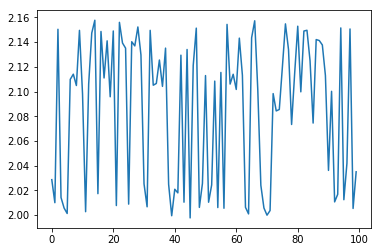

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)